# 순환 신경망으로 IMDB 리뷰 분류하기

<table align="left"><tr><td>
<a href="https://colab.research.google.com/github/rickiepark/hg-mldl2/blob/main/09-2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="코랩에서 실행하기"/></a>
</td></tr></table>

In [1]:
# 실행마다 동일한 결과를 얻기 위해 케라스에 랜덤 시드를 사용하고 텐서플로 연산을 결정적으로 만듭니다.
import keras
import tensorflow as tf

keras.utils.set_random_seed(42)
tf.random.set_seed(42)
tf.config.experimental.enable_op_determinism()

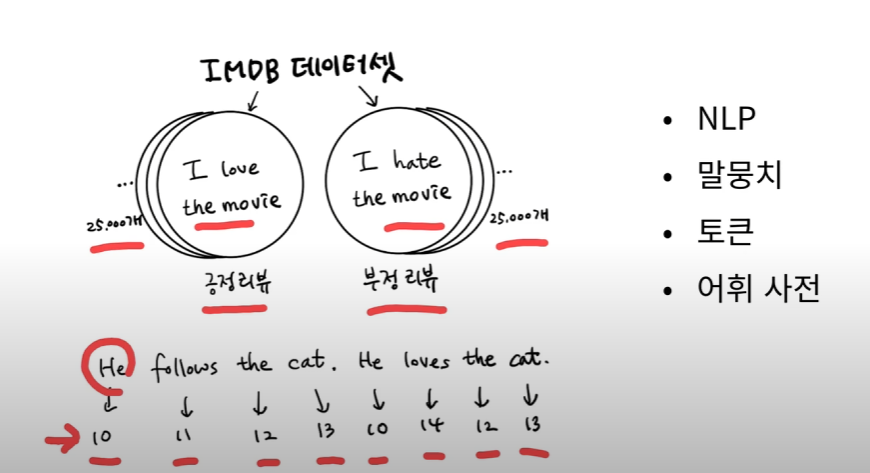

자연어 처리를 하기 위하여 단어마다 고유한 정수를 부여 (토큰화)

## IMDB 리뷰 데이터셋

In [2]:
# 전체 데이터셋에서 가장 자주 등장하는(빈도수가 높은) 단어를 200개만 사용

from keras.datasets import imdb

(train_input, train_target), (test_input, test_target) = imdb.load_data(
    num_words=200)

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
print(train_input.shape, test_input.shape)

(25000,) (25000,)


In [4]:
print(len(train_input[0]))

218


In [5]:
print(len(train_input[1]))

189


In [6]:
# 어휘 사전에 없는 단어는 2 로 표현됨.

print(train_input[0])

[1, 14, 22, 16, 43, 2, 2, 2, 2, 65, 2, 2, 66, 2, 4, 173, 36, 2, 5, 25, 100, 43, 2, 112, 50, 2, 2, 9, 35, 2, 2, 5, 150, 4, 172, 112, 167, 2, 2, 2, 39, 4, 172, 2, 2, 17, 2, 38, 13, 2, 4, 192, 50, 16, 6, 147, 2, 19, 14, 22, 4, 2, 2, 2, 4, 22, 71, 87, 12, 16, 43, 2, 38, 76, 15, 13, 2, 4, 22, 17, 2, 17, 12, 16, 2, 18, 2, 5, 62, 2, 12, 8, 2, 8, 106, 5, 4, 2, 2, 16, 2, 66, 2, 33, 4, 130, 12, 16, 38, 2, 5, 25, 124, 51, 36, 135, 48, 25, 2, 33, 6, 22, 12, 2, 28, 77, 52, 5, 14, 2, 16, 82, 2, 8, 4, 107, 117, 2, 15, 2, 4, 2, 7, 2, 5, 2, 36, 71, 43, 2, 2, 26, 2, 2, 46, 7, 4, 2, 2, 13, 104, 88, 4, 2, 15, 2, 98, 32, 2, 56, 26, 141, 6, 194, 2, 18, 4, 2, 22, 21, 134, 2, 26, 2, 5, 144, 30, 2, 18, 51, 36, 28, 2, 92, 25, 104, 4, 2, 65, 16, 38, 2, 88, 12, 16, 2, 5, 16, 2, 113, 103, 32, 15, 16, 2, 19, 178, 32]


In [7]:
# 부정 (0) 긍정 (1)

print(train_target[:20])

[1 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 1 1 0 1]


In [8]:
from sklearn.model_selection import train_test_split

train_input, val_input, train_target, val_target = train_test_split(
    train_input, train_target, test_size=0.2, random_state=42)

In [9]:
import numpy as np

lengths = np.array([len(x) for x in train_input])

In [10]:
# 샘플의 길이와 중앙값을 가져오고 아래에서 그려보자.

print(np.mean(lengths), np.median(lengths))

239.00925 178.0


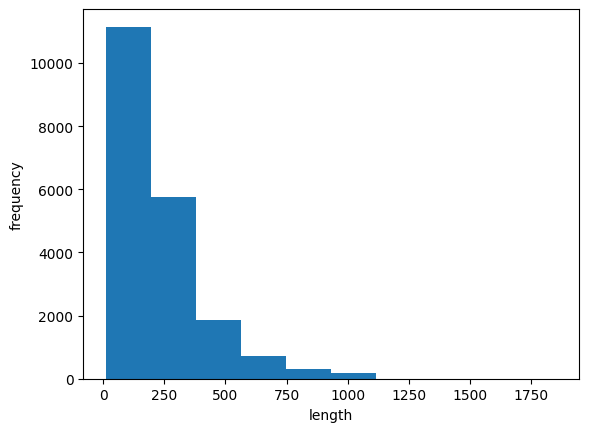

In [11]:
# 길이가 짧은거에 몰려있음. -> 제로패딩과 같이 패딩을 추가하자.

import matplotlib.pyplot as plt

plt.hist(lengths)
plt.xlabel('length')
plt.ylabel('frequency')
plt.show()

In [12]:
# 시퀀스 패딩을 추가

from keras.preprocessing.sequence import pad_sequences

# 길이가 100을 넘으면 자르고, 100이 안된다면 0으로 채운다.
train_seq = pad_sequences(train_input, maxlen=100)

In [13]:
# 25000*(1-0.2)

print(train_seq.shape)

(20000, 100)


In [14]:
# 0번째 값을 출력. -> 길이가 100을 넘어서 자른것 같으나...
# 앞 / 뒤 어디를 자른지 검증해보기.

print(train_seq[0])

[ 10   4  20   9   2   2   2   5  45   6   2   2  33   2   8   2 142   2
   5   2  17  73  17   2   5   2  19  55   2   2  92  66 104  14  20  93
  76   2 151  33   4  58  12 188   2 151  12   2  69   2 142  73   2   6
   2   7   2   2 188   2 103  14  31  10  10   2   7   2   5   2  80  91
   2  30   2  34  14  20 151  50  26 131  49   2  84  46  50  37  80  79
   6   2  46   7  14  20  10  10   2 158]


In [15]:
# 맨 뒤에서 10 개의 번지를 출력 해보았더니,
# 뒤의 10개 값이 같다.
# 즉, 길이가 100을 넘으면 앞에를 자른다.
# --> 시퀀스의 뒷부분의 정보가 더 유용하다고 기대하기 때문.,
# 리뷰 끝에 결정적인 소감을 말할 가능성이 높다고 판단하여서.
# pre 를 post로 바꾸면 뒷부분을 자른다.
print(train_input[0][-10:])

[6, 2, 46, 7, 14, 20, 10, 10, 2, 158]


In [16]:
print(train_seq[5])

[  0   0   0   0   1   2 195  19  49   2   2 190   4   2   2   2 183  10
  10  13  82  79   4   2  36  71   2   8   2  25  19  49   7   4   2   2
   2   2   2  10  10  48  25  40   2  11   2   2  40   2   2   5   4   2
   2  95  14   2  56 129   2  10  10  21   2  94   2   2   2   2  11 190
  24   2   2   7  94   2   2  10  10  87   2  34  49   2   7   2   2   2
   2   2   2   2  46  48  64  18   4   2]


In [17]:
val_seq = pad_sequences(val_input, maxlen=100)

## 순환 신경망 만들기

In [18]:
import keras

model = keras.Sequential()
# 100개의 타임 스탭을 200개의 특성으로 표현한다.
model.add(keras.layers.Input(shape=(100,200)))
model.add(keras.layers.SimpleRNN(8))
model.add(keras.layers.Dense(1, activation='sigmoid'))

In [19]:
train_oh = keras.utils.to_categorical(train_seq)

In [20]:
# 20000개의 데이터, 100개의 차원, 200개의 단어 사전

print(train_oh.shape)

(20000, 100, 200)


원 핫 인코딩을 이용

In [21]:
# I love you 에서 I 의 값이 10 이라면..
# 10번지를 1로 하고 나머지를 다 0 으로 바꾸기.

print(train_oh[0][0][:12])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


In [22]:
print(np.sum(train_oh[0][0]))

1.0


In [23]:
val_oh = keras.utils.to_categorical(val_seq)

In [24]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 8)              │         1,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,681 (6.57 KB)

 Trainable params: 1,681 (6.57 KB)

 Non-trainable params: 0 (0.00 B)

## 순환 신경망 훈련하기

In [25]:
model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-simplernn-model.keras',
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)

history = model.fit(train_oh, train_target, epochs=100, batch_size=64,
                    validation_data=(val_oh, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 37s 103ms/step - accuracy: 0.5031 - loss: 0.7030 - val_accuracy: 0.5288 - val_loss: 0.6906
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 34s 109ms/step - accuracy: 0.5430 - loss: 0.6871 - val_accuracy: 0.5508 - val_loss: 0.6844
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 130ms/step - accuracy: 0.5750 - loss: 0.6766 - val_accuracy: 0.6230 - val_loss: 0.6491
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 29s 93ms/step - accuracy: 0.6670 - loss: 0.6114 - val_accuracy: 0.7000 - val_loss: 0.5772
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 94ms/step - accuracy: 0.7066 - loss: 0.5726 - val_accuracy: 0.7134 - val_loss: 0.5629
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 31s 99ms/step - accuracy: 0.7176 - loss: 0.5589 - val_accuracy: 0.7186 - val_loss: 0.5575
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 38s 122ms/step - accuracy: 0.7232 - loss: 0.5525 - val_accuracy: 0.7248 - val_loss: 0.5524
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 36s 106ms/step - accuracy: 0.7228 - lo

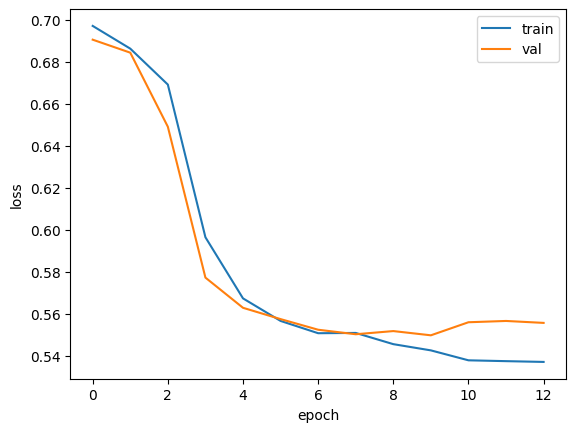

In [26]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [27]:
# 데이터의 크기가 너무 커짐..
print(train_seq.nbytes, train_oh.nbytes)

8000000 3200000000


## 단어 임베딩을 사용하기

In [28]:
# 원핫인코딩이 메모리를 많이 먹어서 임베딩을 사용해보자.
# 오픈소스처럼 미리 되어있는 대규모 말뭉치에서 학습해둔 벡터를 가져다 씀.
# 고정크기의 실수 크기로 변환..

(train_input, train_target), (test_input, test_target) = imdb.load_data(
    num_words=500)
train_input, val_input, train_target, val_target = train_test_split(
    train_input, train_target, test_size=0.2, random_state=42)
train_seq = pad_sequences(train_input, maxlen=100)
val_seq = pad_sequences(val_input, maxlen=100)

In [29]:
model_emb = keras.Sequential()
model_emb.add(keras.layers.Input(shape=(100,)))
# 500개의 단어에 대한 16개의 차원을 추가
model_emb.add(keras.layers.Embedding(500, 16))
model_emb.add(keras.layers.SimpleRNN(8))
model_emb.add(keras.layers.Dense(1, activation='sigmoid'))

In [30]:
model_emb.summary()

# 500*16 = 8000

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 16)        │         8,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 8)              │           200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,209 (32.07 KB)

 Trainable params: 8,209 (32.07 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
model_emb.compile(optimizer='adam', loss='binary_crossentropy',
                  metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-embedding-model.keras',
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)

history = model_emb.fit(train_seq, train_target, epochs=100, batch_size=64,
                        validation_data=(val_seq, val_target),
                        callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 44s 131ms/step - accuracy: 0.5242 - loss: 0.6913 - val_accuracy: 0.5782 - val_loss: 0.6750
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 40s 129ms/step - accuracy: 0.6475 - loss: 0.6377 - val_accuracy: 0.6266 - val_loss: 0.6711
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 47s 147ms/step - accuracy: 0.7178 - loss: 0.5623 - val_accuracy: 0.7384 - val_loss: 0.5396
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 48s 152ms/step - accuracy: 0.7525 - loss: 0.5227 - val_accuracy: 0.7474 - val_loss: 0.5325
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 78s 139ms/step - accuracy: 0.7565 - loss: 0.5137 - val_accuracy: 0.7258 - val_loss: 0.5582
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 40s 128ms/step - accuracy: 0.7851 - loss: 0.4707 - val_accuracy: 0.7466 - val_loss: 0.5255
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 42s 134ms/step - accuracy: 0.7976 - loss: 0.4514 - val_accuracy: 0.7446 - val_loss: 0.5398
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 46s 146ms/step - accuracy: 0.8016 -

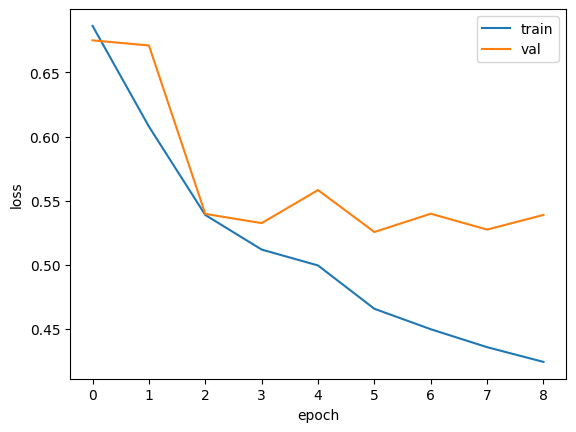

In [32]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()